### Etude du risque du marché

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [144]:
sns.set_theme(style='darkgrid')

In [100]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

In [334]:
data_excel = pd.read_excel('SW_data/environment.xlsx', parse_dates=True)
data_excel.head()

,ISIN,Date,Quote
0,SLFXFSI2 Index,1996-01-05,-0.459
1,SLFXFSI2 Index,1996-01-12,-0.197
2,SLFXFSI2 Index,1996-01-19,-0.190
3,SLFXFSI2 Index,1996-01-26,-0.412
4,SLFXFSI2 Index,1996-02-02,-0.404


In [335]:
tickers = list(data_excel.ISIN.unique())
print('Tickers : \n')
print('\n'.join(map(str, tickers))) 

Tickers : 

SLFXFSI2 Index
VIX Index
BICLB10Y Index
SPXT Index


In [337]:
data = data_excel.pivot(columns='ISIN', index='Date').fillna(method='ffill', limit=7).dropna()
data.columns = data.columns.droplevel()
data = data.drop(columns=['BICLB10Y Index'])
data.columns = ['Stress', 'SP500', 'VIX']
data.index.name = 'Date'
data.columns.name = None
data.head(5)

,Stress,SP500,VIX
Date,,,
1996-01-05,-0.459,793.20,13.58
1996-01-08,-0.459,795.68,13.11
1996-01-09,-0.459,784.16,15.21
1996-01-10,-0.459,770.11,16.40
1996-01-11,-0.459,775.56,14.69
1996-01-12,-0.197,774.43,14.23
1996-01-15,-0.197,771.87,14.99
1996-01-16,-0.197,782.97,14.09
1996-01-17,-0.197,780.37,14.25


In [340]:
spread_excel = pd.read_excel('SW_data/spread.xlsx', parse_dates=True, index_col=1).drop(columns=['ISIN'])
spread_excel = spread_excel.reindex(data.index, method='ffill')
spread_excel.head()

,Quote
Date,
1996-01-05,3.84
1996-01-08,3.84
1996-01-09,3.84
1996-01-10,3.84
1996-01-11,3.84


In [341]:
data['Spread'] = spread_excel.values
data.head()

,Stress,SP500,VIX,Spread
Date,,,,
1996-01-05,-0.459,793.20,13.58,3.84
1996-01-08,-0.459,795.68,13.11,3.84
1996-01-09,-0.459,784.16,15.21,3.84
1996-01-10,-0.459,770.11,16.40,3.84
1996-01-11,-0.459,775.56,14.69,3.84


In [342]:
data_stress = data_excel[data_excel.ISIN == 'SLFXFSI2 Index']
data_stress.index = data_stress.Date
data_stress = data_stress[['Quote']]
data_stress = data_stress.shift(1)
data_stress = data_stress.reindex(data.index, method='ffill')
data.Stress = data_stress.values
data.head(10)

,Stress,SP500,VIX,Spread
Date,,,,
1996-01-05,NaN,793.20,13.58,3.84
1996-01-08,NaN,795.68,13.11,3.84
1996-01-09,NaN,784.16,15.21,3.84
1996-01-10,NaN,770.11,16.40,3.84
1996-01-11,NaN,775.56,14.69,3.84
1996-01-12,-0.459,774.43,14.23,3.84
1996-01-15,-0.459,771.87,14.99,3.84
1996-01-16,-0.459,782.97,14.09,3.84
1996-01-17,-0.459,780.37,14.25,3.84


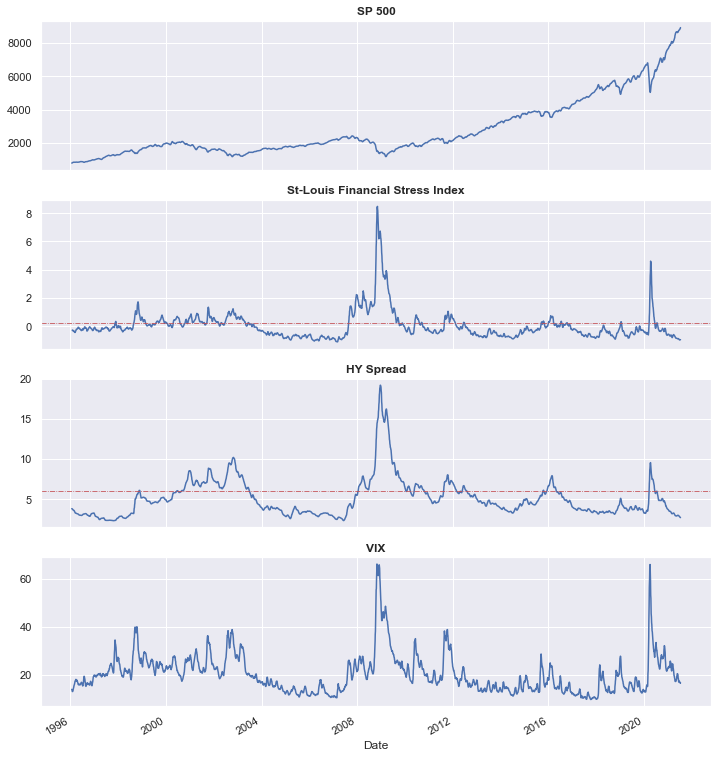

In [343]:
fig, axs = plt.subplots(4, 1, figsize=(12,14), sharex=True)
data.SP500.rolling(15).mean().plot(ax=axs[0], label='SP500')
axs[0].set_title('SP 500', fontweight='bold')
axs[0].grid(b=True)

data.Stress.rolling(15).mean().plot(ax=axs[1])
axs[1].set_title('St-Louis Financial Stress Index', fontweight='bold')
axs[1].axhline(y=0.2, linestyle='-.', c='r', lw=0.8)
axs[1].grid(b=True)

data.Spread.rolling(15).mean().plot(ax=axs[2])
axs[2].set_title('HY Spread', fontweight='bold')
axs[2].axhline(y=6, linestyle='-.', c='r', lw=0.8)
axs[2].grid(b=True)

data.VIX.rolling(15).mean().plot(ax=axs[3])
axs[3].set_title('VIX', fontweight='bold')
axs[3].grid(b=True)

plt.show()

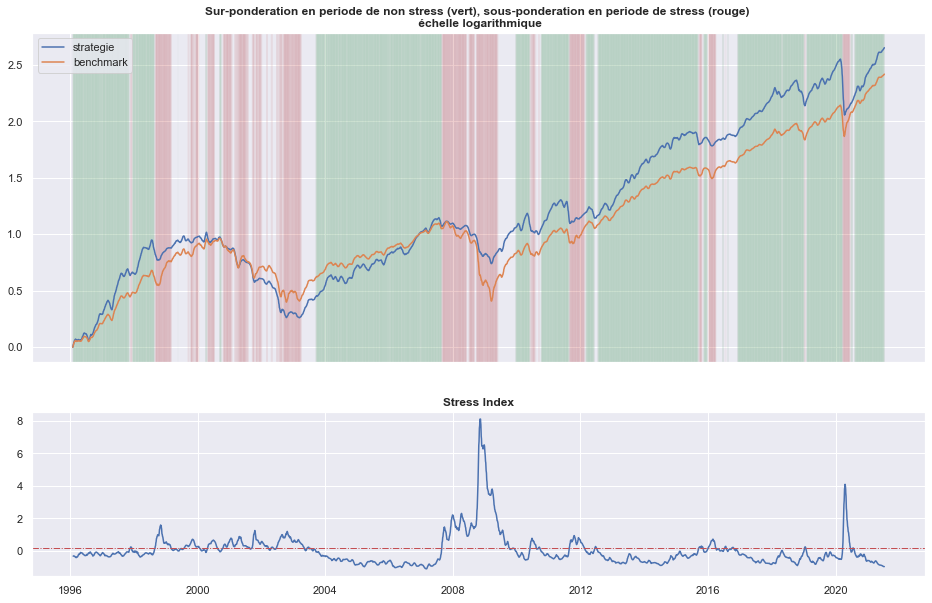

In [368]:
### Stratégie de base

df_stress = pd.DataFrame(index=data.index)
df_stress['stress'] = data.Stress
# Premiere pente
df_stress['dx100'] = df_stress.stress.rolling(200).apply(lambda x: (x[-1] - x[0]) / len(x))
# Deuxieme pente
df_stress['ddx100'] = df_stress.dx100.rolling(100).apply(lambda x: (x[-1] - x[0]) / len(x))
# 1 si premiere pente positive, 0 sinon
df_stress['signal_dx'] = (df_stress.dx100 > 0).astype(int)

window_mean = 21
for idx in df_stress.index:
    iloc = df_stress.index.get_loc(idx)
    
    # 1 si moyenne des 15 derniers jours > 0.2
    if (df_stress.stress.iloc[iloc - window_mean:iloc].mean() > 0.2):
        df_stress.at[idx, 'signal_stress'] = 1
    # -1 si moyenne des 15 derniers jours < 0
    elif (df_stress.stress.iloc[iloc - window_mean:iloc].mean() < -0):
        df_stress.at[idx, 'signal_stress'] = -1
    else:
        df_stress.at[idx, 'signal_stress'] = 0
    
    # signal final: stress > 0.2, et pente positive => 1
    if (df_stress.signal_stress.loc[idx] == 1) & (df_stress.signal_dx.loc[idx] == 1):
        df_stress.at[idx, 'signal'] = 1
    elif (df_stress.signal_stress.loc[idx] == -1):
        df_stress.at[idx, 'signal'] = -1
    else:
        df_stress.at[idx, 'signal'] = 0

# 50% du return de l'indice quand Stress, 150% quand Non Stress, et 100% sinon
df_stress['weight'] = df_stress.signal.replace({0: 1, 1: 0.5, -1: 1.5})

df_stress['strategie'] = df_stress.weight * data.SP500.pct_change()

### plot
fig, axs = plt.subplots(2, 1, figsize=(16,10), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

sns.lineplot(ax=axs[0], data=np.log((1 + df_stress.strategie).cumprod().rolling(20).mean()), label='strategie')
sns.lineplot(ax=axs[0], data=np.log((1 + data.SP500.pct_change()).cumprod().rolling(20).mean()), label='benchmark')
for idx in df_stress.index:
    iloc = df_stress.index.get_loc(idx)
    if (df_stress.signal.loc[idx] == 1):
        axs[0].axvline(x=idx, lw=0.4, alpha=0.1, zorder=1, c='r')
    if (df_stress.signal.loc[idx] == -1):
        axs[0].axvline(x=idx, lw=0.4, alpha=0.1, zorder=1, c='g')
axs[0].set_title('Sur-ponderation en periode de non stress (vert), sous-ponderation en periode de stress (rouge) \n échelle logarithmique', fontsize=12, fontweight='bold')   
axs[0].set_xlabel(None)
axs[0].set_ylabel(None)
axs[0].legend(loc='upper left')

sns.lineplot(ax=axs[1], data=df_stress.stress.rolling(20).mean())
axs[1].axhline(y=0.2, linestyle='-.', c='r', lw=1)
axs[1].set_title('Stress Index', fontsize=12, fontweight='bold')  
axs[1].set_xlabel(None)
axs[1].set_ylabel(None)

plt.show()

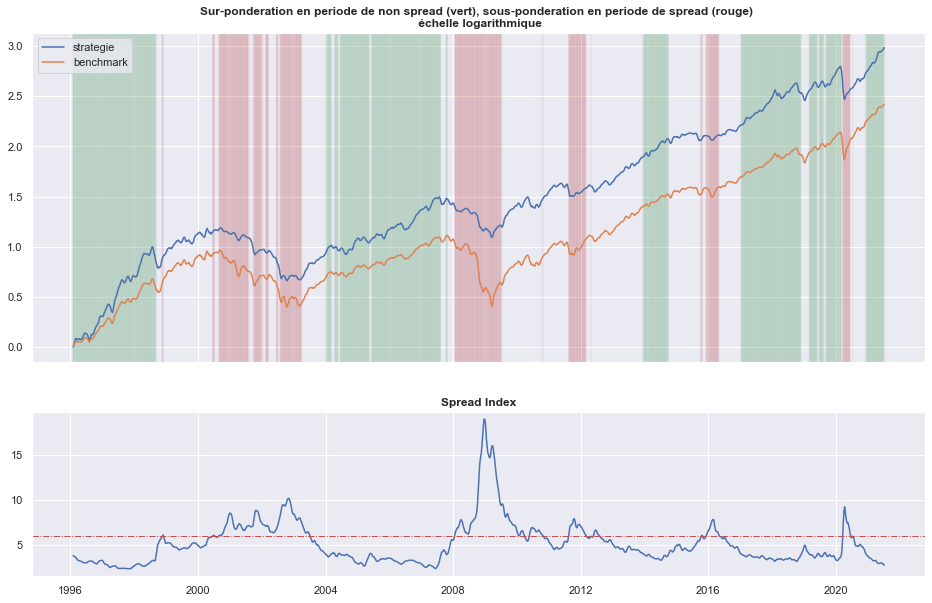

In [374]:
### Stratégie de base

df_spread = pd.DataFrame(index=data.index)
df_spread['spread'] = data.Spread
# Premiere pente
df_spread['dx100'] = df_spread.spread.rolling(200).apply(lambda x: (x[-1] - x[0]) / len(x))
# Deuxieme pente
df_spread['ddx100'] = df_spread.dx100.rolling(100).apply(lambda x: (x[-1] - x[0]) / len(x))
# 1 si premiere pente positive, 0 sinon
df_spread['signal_dx'] = (df_spread.dx100 > 0).astype(int)

for idx in df_spread.index:
    iloc = df_spread.index.get_loc(idx)
    
    # 1 si moyenne des 15 derniers jours > 6
    if (df_spread.spread.iloc[iloc - 15:iloc].mean() > 6):
        df_spread.at[idx, 'signal_spread'] = 1
    # -1 si moyenne des 15 derniers jours < 0
    elif (df_spread.spread.iloc[iloc - 15:iloc].mean() < 4):
        df_spread.at[idx, 'signal_spread'] = -1
    else:
        df_spread.at[idx, 'signal_spread'] = 0
    
    # signal final: spread > 0.2, et pente positive => 1
    if (df_spread.signal_spread.loc[idx] == 1) & (df_spread.signal_dx.loc[idx] == 1):
        df_spread.at[idx, 'signal'] = 1
    elif (df_spread.signal_spread.loc[idx] == -1):
        df_spread.at[idx, 'signal'] = -1
    else:
        df_spread.at[idx, 'signal'] = 0

# 50% du return de l'indice quand spread > 6, 150% quand spread < 4, et 100% sinon
df_spread['weight'] = df_spread.signal.replace({0: 1, 1: 0.5, -1: 1.5})

df_spread['strategie'] = df_spread.weight * data.SP500.pct_change()
df_spread.head(20)

### plot
fig, axs = plt.subplots(2, 1, figsize=(16,10), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

sns.lineplot(ax=axs[0], data=np.log((1 + df_spread.strategie).cumprod().rolling(20).mean()), label='strategie')
sns.lineplot(ax=axs[0], data=np.log((1 + data.SP500.pct_change()).cumprod().rolling(20).mean()), label='benchmark')
for idx in df_spread.index:
    iloc = df_spread.index.get_loc(idx)
    if (df_spread.signal.loc[idx] == 1):
        axs[0].axvline(x=idx, lw=0.4, alpha=0.1, zorder=1, c='r')
    if (df_spread.signal.loc[idx] == -1):
        axs[0].axvline(x=idx, lw=0.4, alpha=0.1, zorder=1, c='g')
axs[0].set_title('Sur-ponderation en periode de non spread (vert), sous-ponderation en periode de spread (rouge) \n échelle logarithmique', fontsize=12, fontweight='bold')   
axs[0].set_xlabel(None)
axs[0].set_ylabel(None)
axs[0].legend(loc='upper left')

sns.lineplot(ax=axs[1], data=df_spread.spread.rolling(20).mean())
axs[1].axhline(y=6, linestyle='-.', c='r', lw=1)
axs[1].set_title('Spread Index', fontsize=12, fontweight='bold')  
axs[1].set_xlabel(None)
axs[1].set_ylabel(None)

plt.show()

In [370]:
df_risque = pd.DataFrame().reindex(df_spread.index)
df_risque['stress'] = df_stress.stress
df_risque['spread'] = df_spread.spread
df_risque

,stress,spread
Date,,
1996-01-05,NaN,3.840000
1996-01-08,NaN,3.840000
1996-01-09,NaN,3.840000
1996-01-10,NaN,3.840000
1996-01-11,NaN,3.840000
...,...,...
2021-07-02,-0.966,2.671710
2021-07-06,-0.966,2.624195
2021-07-07,-0.966,2.629321


In [375]:
for idx in df_risque.index:
    if (df_risque.at[idx, 'stress'] < 0.2) & (df_risque.at[idx, 'spread'] < 6):
        df_risque.at[idx, 'signal'] = 1
    if (df_risque.at[idx, 'stress'] > 0.2) & (df_risque.at[idx, 'spread'] > 6):
        df_risque.at[idx, 'signal'] = -1
    if (df_risque.at[idx, 'stress'] < 0.2) & (df_risque.at[idx, 'spread'] > 6):
        df_risque.at[idx, 'signal'] = 0.5
    if (df_risque.at[idx, 'stress'] > 0.2) & (df_risque.at[idx, 'spread'] < 6):
        df_risque.at[idx, 'signal'] = -0.5

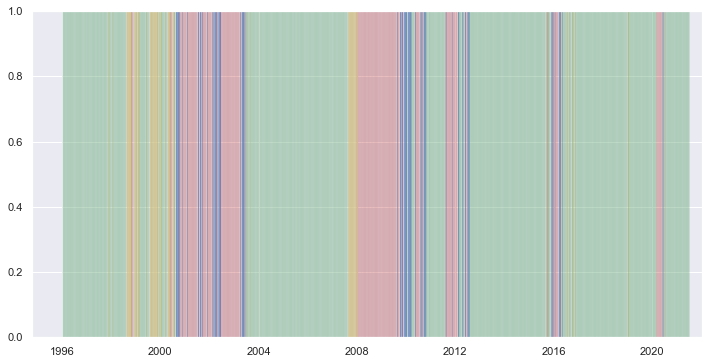

In [383]:
fig, ax = plt.subplots(figsize=(12,6))

for idx in df_risque.index:
    if (df_risque.signal.loc[idx] == 1):
        ax.axvline(x=idx, lw=0.4, alpha=0.1, zorder=1, c='g')
    if (df_risque.signal.loc[idx] == -1):
        ax.axvline(x=idx, lw=0.4, alpha=0.1, zorder=1, c='r')
    if (df_risque.signal.loc[idx] == -0.5):
        ax.axvline(x=idx, lw=1, alpha=0.1, zorder=1, c='y')
    if (df_risque.signal.loc[idx] == 0.5):
        ax.axvline(x=idx, lw=1, alpha=0.1, zorder=1, c='b')